In [ ]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import MultipleLocator
import sys
import os
from dotenv import load_dotenv

load_dotenv()
HOPSWORKS_API_KEY = os.getenv("HOPSWORKS_API_KEY")


In [2]:
root_dir = Path().absolute()
# Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
if root_dir.parts[-1:] == ('notebooks',):
    root_dir = Path(*root_dir.parts[:-1])
    sys.path.append(str(root_dir))
if root_dir.parts[-1:] == ('airquality',):
    root_dir = Path(*root_dir.parts[:-1])
    sys.path.append(str(root_dir))
root_dir = str(root_dir) 
root_dir

'/Users/nsharma14/Personal/code/pollutionchecker'

In [ ]:
#model_path = Path("downloaded_model_dir") / "model.json"
#xgb_model = XGBRegressor()
#xgb_model.load_model(str(model_path))
#xgb_model

In [ ]:
project = hopsworks.login(
    project='airquality',  # Replace with your project name
    host="eu-west.cloud.hopsworks.ai",
    port=443,
    api_key_value=HOPSWORKS_API_KEY  # Get from Hopsworks UI > Account Settings > API Keys
)

In [4]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2026, 2, 6, 9, 15, 5, 691003)

In [5]:

fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

In [6]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

fv = retrieved_model.get_feature_view()



2026-02-06 09:15:32,209 INFO: Initializing for batch retrieval of feature vectors


In [ ]:
# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

In [ ]:


#model_path = Path(saved_model_dir) / "model.json"
xgb_model = XGBRegressor()
#xgb_model.load_model(str(model_path))
xgb_model.load_model(saved_model_dir + "/model.json")
xgb_model


In [ ]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()

In [ ]:
batch_data['predicted_pm25'] = xgb_model.predict(
    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])

In [ ]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])


In [11]:

def plot_air_quality_forecast(city: str, street: str, df: pd.DataFrame, file_path: str, hindcast=False):
    fig, ax = plt.subplots(figsize=(10, 6))

    day = pd.to_datetime(df['date']).dt.date
    # Plot each column separately in matplotlib
    ax.plot(day, df['predicted_pm25'], label='Predicted PM2.5', color='red', linewidth=2, marker='o', markersize=5, markerfacecolor='blue')

    # Set the y-axis to a logarithmic scale
    ax.set_yscale('log')
    ax.set_yticks([0, 10, 25, 50, 100, 250, 500])
    ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
    ax.set_ylim(bottom=1)

    # Set the labels and title
    ax.set_xlabel('Date')
    ax.set_title(f"PM2.5 Predicted (Logarithmic Scale) for {city}, {street}")
    ax.set_ylabel('PM2.5')

    colors = ['green', 'yellow', 'orange', 'red', 'purple', 'darkred']
    labels = ['Good', 'Moderate', 'Unhealthy for Some', 'Unhealthy', 'Very Unhealthy', 'Hazardous']
    ranges = [(0, 49), (50, 99), (100, 149), (150, 199), (200, 299), (300, 500)]
    for color, (start, end) in zip(colors, ranges):
        ax.axhspan(start, end, color=color, alpha=0.3)

    # Add a legend for the different Air Quality Categories
    patches = [Patch(color=colors[i], label=f"{labels[i]}: {ranges[i][0]}-{ranges[i][1]}") for i in range(len(colors))]
    legend1 = ax.legend(handles=patches, loc='upper right', title="Air Quality Categories", fontsize='x-small')

    # Aim for ~10 annotated values on x-axis, will work for both forecasts ans hindcasts
    if len(df.index) > 11:
        every_x_tick = len(df.index) / 10
        ax.xaxis.set_major_locator(MultipleLocator(every_x_tick))

    plt.xticks(rotation=45)

    if hindcast == True:
        ax.plot(day, df['pm25'], label='Actual PM2.5', color='black', linewidth=2, marker='^', markersize=5, markerfacecolor='grey')
        legend2 = ax.legend(loc='upper left', fontsize='x-small')
        ax.add_artist(legend1)

    # Ensure everything is laid out neatly
    plt.tight_layout()

    # # Save the figure, overwriting any existing file with the same name
    plt.savefig(file_path)
    return plt

def backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, model):
    features_df = weather_fg.read()
    features_df = features_df.sort_values(by=['date'], ascending=True)
    features_df = features_df.tail(10)
    features_df['predicted_pm25'] = model.predict(features_df[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
    df = pd.merge(features_df, air_quality_df[['date','pm25','street','country']], on="date")
    df['days_before_forecast_day'] = 1
    hindcast_df = df
    df = df.drop('pm25', axis=1)
    monitor_fg.insert(df, write_options={"wait_for_job": True})
    return hindcast_df

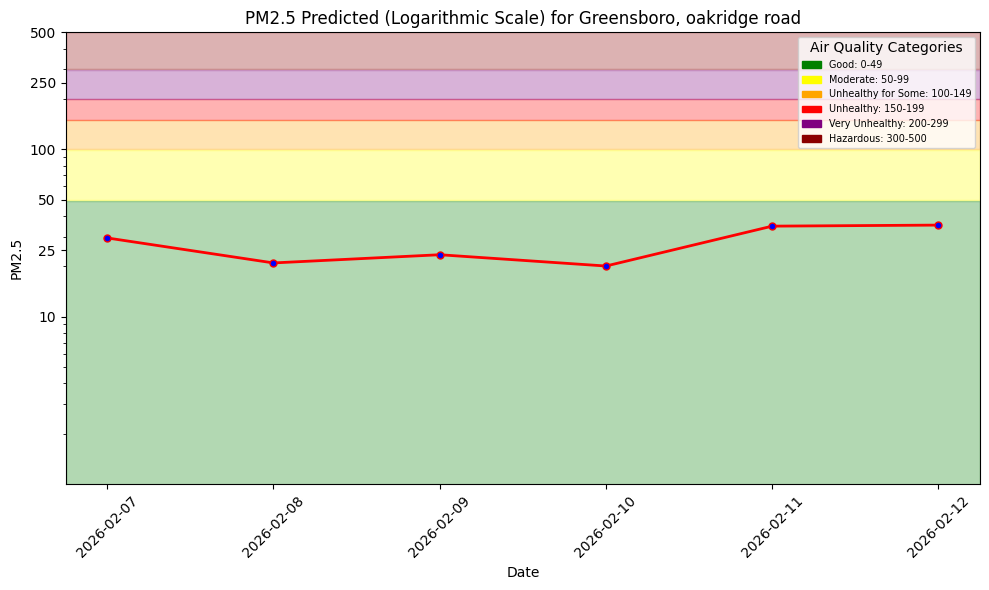

In [ ]:

pred_file_path = f"{root_dir}/docs/air-quality/img/pm25_forecast.png"
plt = plot_air_quality_forecast(city, street, batch_data, pred_file_path)

plt.show()

In [13]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [14]:
monitor_fg.insert(batch_data, wait=True)

2026-02-06 09:05:59,892 INFO: Computing insert statistics


(None, None)

In [15]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.01s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2026-02-07,-7.869000,0.0,37.008278,322.907074,Greensboro,29.564438,oakridge road,USA,1
1,2026-02-02,-6.599999,0.0,18.440998,292.763153,Greensboro,24.428225,oakridge road,USA,1
2,2026-02-03,-0.756250,0.0,13.510796,253.728119,Greensboro,31.913486,oakridge road,USA,1
3,2026-02-04,1.714583,0.4,15.210799,18.435040,Greensboro,21.128843,oakridge road,USA,1
4,2026-02-06,-6.519000,0.0,4.829907,243.435013,Greensboro,29.870321,oakridge road,USA,1


In [16]:
air_quality_fg = fs.get_feature_group(name='air_quality', version=1)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.28s) 


,date,pm25,country,city,street,url
0,2026-02-05,50.0,USA,Greensboro,oakridge road,https://api.waqi.info/feed/@8883
1,2026-02-02,18.0,USA,Greensboro,oakridge road,https://api.waqi.info/feed/@8883
2,2026-02-03,22.0,USA,Greensboro,oakridge road,https://api.waqi.info/feed/@8883
3,2026-02-04,39.0,USA,Greensboro,oakridge road,https://api.waqi.info/feed/@8883
4,2026-02-06,44.0,USA,Greensboro,oakridge road,https://api.waqi.info/feed/@8883
...,...,...,...,...,...,...
3548,2016-03-28,27.0,USA,Greensboro,oakridge road,https://api.waqi.info/feed/@8883
3549,2016-03-29,18.0,USA,Greensboro,oakridge road,https://api.waqi.info/feed/@8883
3550,2016-03-30,24.0,USA,Greensboro,oakridge road,https://api.waqi.info/feed/@8883
3551,2016-03-31,30.0,USA,Greensboro,oakridge road,https://api.waqi.info/feed/@8883


In [17]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, xgb_model)
hindcast_df

,date,predicted_pm25,pm25
0,2026-02-02,24.428225,18.0
1,2026-02-03,31.913486,22.0
2,2026-02-04,21.128843,39.0
3,2026-02-06,29.870321,44.0


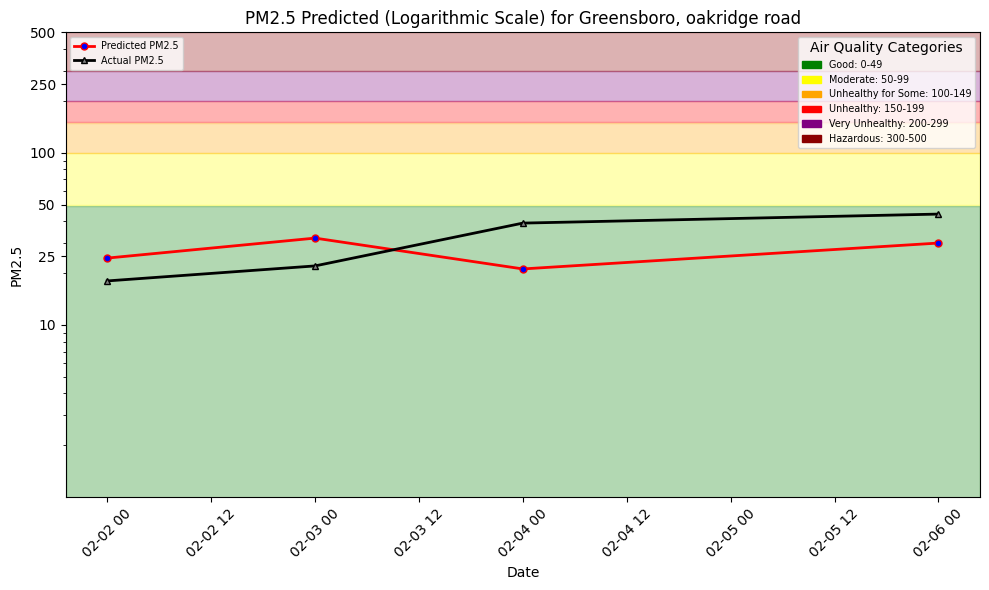

In [ ]:
hindcast_file_path = f"{root_dir}/docs/air-quality/img/pm25_hindcast_1day.png"
plt = plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
plt.show()

In [19]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading /Users/nsharma14/Personal/code/pollutionchecker/notebooks/docs/air-quality/img/pm25_forecast.png: 0.…

Uploading /Users/nsharma14/Personal/code/pollutionchecker/notebooks/docs/air-quality/img/pm25_hindcast_1day.pn…

See images in Hopsworks here: https://eu-west.cloud.hopsworks.ai:443/p/4234/settings/fb/path/Resources/airquality
